# Урок 7. Рекурентные сети для обработки последовательностей
Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
!pip install torchmetrics
!pip install stop_words
!pip install nltk

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")

from string import punctuation
from stop_words import get_stop_words
# from pymorphy2 import MorphAnalyzer

import re

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\orlov\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\orlov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\orlov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
max_words = 1000
max_len = 10
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [15]:
train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')')

In [16]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [17]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [18]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [19]:
X_train.label.value_counts()

0    22288
1     1683
Name: label, dtype: int64

In [20]:
X_valid.label.value_counts()

0    7432
1     559
Name: label, dtype: int64

In [21]:
sw = set(get_stop_words("en"))

In [22]:
puncts = set(punctuation)

In [23]:
morpher = WordNetLemmatizer()
morpher.lemmatize('dogs')

'dog'

In [24]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [25]:
# train_df.tweet.iloc[:1].values

In [26]:
# train_df.tweet.iloc[:1].apply(preprocess_text).values

In [27]:
from tqdm import tqdm 
tqdm.pandas()

X_train.tweet = X_train.tweet.progress_apply(preprocess_text)
X_valid.tweet = X_valid.tweet.progress_apply(preprocess_text)

100%|██████████| 7991/7991 [00:00<00:00, 15000.08it/s]


In [28]:
train_corpus = " ".join(X_train.tweet)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:5]

['weekend', 'world', 'really', 'going', 'bonkers']

In [29]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [30]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

999

In [31]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'u', 'happy', 'amp', 'just', 'will', 'time', 'life']

In [32]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [33]:
def text_to_sequence(text, maxlen):
    
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()] # проверка чтобы токен был либо буквенный либо символьный
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    
    return result[-maxlen:] + padding

In [34]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_valid.tweet])

x_train.shape, x_val.shape

((23971, 10), (7991, 10))

In [35]:
train_df.tweet.iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [36]:
x_train[0]

array([35,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [37]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [38]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # если индексы инты то делать лучше лонг - иначе может сломаться вдруг -
        # так как на инт меньше памяти выделяется на каждое значение и может переполниться
        self.target = torch.from_numpy(target).long() # какие то ф-и потерь на интах не считается - а только на лонгах
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [39]:
train_dataset = DataWrapper(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_valid.label.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [40]:
train_loader.sampler

In [41]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [43]:
model = GRUFixedLen(max_words).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [44]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(1000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 326273


In [51]:
train_f1_score = torchmetrics.F1Score(task='binary')
test_f1_score = torchmetrics.F1Score(task='binary')

In [52]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right, all_f1_score_train = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        train_f1_score(outputs.squeeze(), labels)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        all_f1_score_train += train_f1_score.compute().item()
        
    # выводим статистику о процессе обучения (переводим модель в валидацию)
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. \n' \
            f'Train: Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}, ' \
            f'f1_score_train: {all_f1_score_train / (i+1):.3f}, ')

    
    running_loss, running_items, running_right, all_f1_score_train = 0.0, 0.0, 0.0, 0.0
    train_f1_score.reset()
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss, all_f1_score_test = 0.0, 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        
        test_outputs = model(data[0].to(device))
        test_labels = data[1].to(device)

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_f1_score(test_outputs.squeeze(), test_labels)
        
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
        
        all_f1_score_test += test_f1_score.compute().item()

    test_loss_history.append(test_loss.item())
    print(f'Test:  Loss: {test_loss:.3f}. Acc: {test_running_right / test_running_total:.3f},', end=' ')
    
    print(f'f1_score_test:  {all_f1_score_test / (j+1):.3f}\n')
    test_f1_score.reset()
    
    model.train()
        
print('done')

Epoch [1/15]. Step [47/47]. 
Train: Loss: 0.188. Acc: 0.920, f1_score_train: 0.066, 
Test:  Loss: 0.561. Acc: 0.937, f1_score_test:  0.296

Epoch [2/15]. Step [47/47]. 
Train: Loss: 0.132. Acc: 0.940, f1_score_train: 0.347, 
Test:  Loss: 0.057. Acc: 0.946, f1_score_test:  0.465

Epoch [3/15]. Step [47/47]. 
Train: Loss: 0.206. Acc: 0.948, f1_score_train: 0.455, 
Test:  Loss: 0.562. Acc: 0.948, f1_score_test:  0.519

Epoch [4/15]. Step [47/47]. 
Train: Loss: 0.113. Acc: 0.951, f1_score_train: 0.558, 
Test:  Loss: 0.297. Acc: 0.947, f1_score_test:  0.506

Epoch [5/15]. Step [47/47]. 
Train: Loss: 0.105. Acc: 0.953, f1_score_train: 0.580, 
Test:  Loss: 0.003. Acc: 0.947, f1_score_test:  0.591

Epoch [6/15]. Step [47/47]. 
Train: Loss: 0.131. Acc: 0.955, f1_score_train: 0.612, 
Test:  Loss: 0.032. Acc: 0.948, f1_score_test:  0.534

Epoch [7/15]. Step [47/47]. 
Train: Loss: 0.121. Acc: 0.957, f1_score_train: 0.645, 
Test:  Loss: 0.442. Acc: 0.946, f1_score_test:  0.508

Epoch [8/15]. Step [

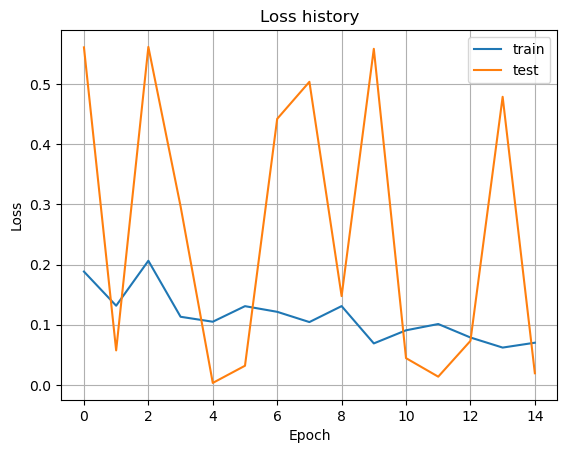

In [53]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

с увеличеснием количества слов растет точность на тесте, однако также и растет переобучение